In [76]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
%matplotlib inline

dash = pd.read_csv('/home/ml/datasets/DASH240.csv',delimiter=',', parse_dates=[['Date', 'Time']])
dash.head(1)

ValueError: 'Date' is not in list

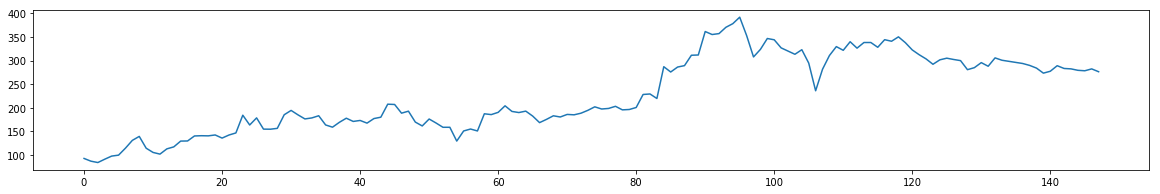

In [41]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="Close")

In [42]:
def get_direction(pct_change): 
    dt = np.sign(pct_change)
    result = pd.DataFrame({'Direction': dt})
    return result

In [43]:
def get_privot_dot(price_close, min_value,max_value):
    privot_dot = (price_close + max_value + min_value)/3
    return privot_dot  

In [44]:
def get_resistors(privot_dot,min_value,max_value):
    r1 = 2*privot_dot-min_value
    r2 = privot_dot+max_value-min_value
    r3 = 2*(privot_dot-min_value)+max_value
    result = pd.DataFrame({'R1': r1, 'R2': r2, 'R3': r3})
    return result

In [45]:
def get_supports(privot_dot,min_value,max_value):
    s1 = 2*privot_dot-max_value
    s2 = privot_dot-max_value-min_value
    s3 = min_value-(2*(max_value-privot_dot))
    result = pd.DataFrame({'S1': s1, 'S2': s2, 'S3': s3})
    return result

In [46]:
def get_bollinger_bands(price_close, window_size, num_of_std):
    rolling_mean = price_close.rolling(window=window_size,min_periods=1).mean()
    rolling_std= price_close.rolling(window=window_size,min_periods=1).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    result = pd.DataFrame({'BB_Mean': rolling_mean, 'BB_Upper': upper_band, 'BB_Lower': lower_band})
    return result

In [47]:
def get_moving_average_convergence(price_close, nslow=26, nfast=12):
    emaslow = price_close.ewm(span=nslow, min_periods=1).mean()
    emafast = price_close.ewm(span=nfast, min_periods=1).mean()
    macd = emafast-emaslow
    result = pd.DataFrame({'MACD': macd, 'EMA_26': emaslow, 'EMA_12': emafast})
    return result

In [48]:
def get_relative_stength_index(up_array, down_array,window_size=14):
    up_array[up_array < 0] = 0
    down_array[down_array > 0] = 0

    rolUp = up_array.rolling(window=window_size,min_periods=1).mean()
    rolDown = down_array.rolling(window=window_size,min_periods=1).mean().abs()
    rs = rolUp / rolDown
    avgUp = rolUp/window_size
    avgDown = rolDown/window_size
    rsi = 100*((avgUp)/(avgUp+avgDown))
    
    result = pd.DataFrame({'RSI': rsi})
    return result

In [49]:
def get_true_range(price_close, price_max, price_min):
    tr1 = price_max-dash['Min']
    tr2 = price_max-price_close.shift(-1)
    tr2 = tr2.abs()
    tr3 = price_min-price_close.shift(-1)
    tr3 = tr3.abs()

    TR = pd.DataFrame({'TR1': tr1, 'TR2': tr2, 'TR3': tr3,})
    TR = TR[['TR1', 'TR2', 'TR3']].max(axis=1)
    result = pd.DataFrame({'TR': TR}) 
    
    return result

In [50]:
def get_average_true_range(tr, window_size=14):
    rsi = tr.ewm(span=window_size, min_periods=1).mean()
    result = pd.DataFrame({'ATR': rsi})
    return result

In [51]:
def get_parabolic_stop_and_reversal(s, af=0.02, amax=0.2):
    high, low = s.Max, s.Min

    sig0, xpt0, af0 = True, high[0], af
    sar = [low[0] - (high - low).std()]

    for i in range(1, len(s)):
        sig1, xpt1, af1 = sig0, xpt0, af0

        lmin = min(low[i - 1], low[i])
        lmax = max(high[i - 1], high[i])

        if sig1:
            sig0 = low[i] > sar[-1]
            xpt0 = max(lmax, xpt1)
        else:
            sig0 = high[i] >= sar[-1]
            xpt0 = min(lmin, xpt1)

        if sig0 == sig1:
            sari = sar[-1] + (xpt1 - sar[-1])*af1
            af0 = min(amax, af1 + af)

            if sig0:
                af0 = af0 if xpt0 > xpt1 else af1
                sari = min(sari, lmin)
            else:
                af0 = af0 if xpt0 < xpt1 else af1
                sari = max(sari, lmax)
        else:
            af0 = af
            sari = xpt0

        sar.append(sari)
    
    result = pd.DataFrame({'PSAR': sar})
    return result

In [52]:
get_moving_average_convergence(dash['Close']).tail(1)

,EMA_12,EMA_26,MACD
147,283.586644,290.949129,-7.362486


In [53]:
dash['SMA14'] = dash['Close'].rolling(window=14,min_periods=1).mean()
dash['SMA30'] = dash['Close'].rolling(window=30,min_periods=1).mean()
dash['EMA14'] = dash['Close'].ewm(span=14,min_periods=1).mean()
dash['EMA30'] = dash['Close'].ewm(span=30,min_periods=1).mean()

In [54]:
num_of_std = dash['Close'].std()
get_bollinger_bands(dash['Close'],20,num_of_std).head(5)

,BB_Lower,BB_Mean,BB_Upper
0,NaN,92.850000,NaN
1,-237.367870,89.955000,417.277870
2,-264.292787,88.036667,440.366121
3,-226.210955,88.840000,403.890955
4,-331.249272,90.640000,512.529272


In [55]:
min_values = dash['Min']
max_values = dash['Max']
close_values = dash['Close']
privot_dots = get_privot_dot(close_values,min_values,max_values)
dash['Privot_Dot'] = privot_dots

get_supports(privot_dots,min_values,max_values).tail(3)

,S1,S2,S3
145,271.973333,-275.943333,260.153333
146,278.526667,-282.186667,270.736667
147,274.050000,-281.040000,266.880000


In [56]:
get_resistors(privot_dots,min_values,max_values).tail(3)

,R1,R2,R3
145,283.793333,289.056667,295.613333
146,286.316667,290.133333,294.106667
147,281.220000,285.940000,288.390000


In [57]:
dash['Pct_Change'] = dash['Close'].pct_change()

In [58]:
dUp, dDown = dash['Pct_Change'].copy(), dash['Pct_Change'].copy()
get_relative_stength_index(dUp,dDown).head()

,RSI
0,NaN
1,0.000000
2,0.000000
3,46.792105
4,62.091762


In [59]:
get_true_range(dash['Close'], dash['Max'], dash['Min']).head()

,TR
0,9.05
1,9.34
2,11.52
3,13.64
4,16.14


In [60]:
get_parabolic_stop_and_reversal(dash).head()

,PSAR
0,70.629980
1,71.093580
2,71.547909
3,71.993151
4,72.429488


In [61]:
dash['TR'] = get_true_range(dash['Close'], dash['Max'], dash['Min'])

In [62]:
resitor_df = get_resistors(privot_dots,min_values,max_values)
support_df = get_supports(privot_dots,min_values,max_values)
bollinger_df = get_bollinger_bands(dash['Close'],20,num_of_std)
macd_df = get_moving_average_convergence(dash['Close'])
rsi_df = get_relative_stength_index(dUp,dDown)
atr_df = get_average_true_range(dash['TR'])
psar_df = get_parabolic_stop_and_reversal(dash) 

dash_raw = dash.copy()

dash = pd.concat([dash_raw, resitor_df, support_df, bollinger_df, macd_df, rsi_df, atr_df,psar_df], axis=1)

In [63]:
#dash.loc[dash['Pct_Change'] == 0, 'Pct_Change'] = 1

In [64]:
diff = np.ediff1d(dash[['Close']])
diff_df = pd.DataFrame([dash.Close,np.ediff1d(dash[['Close']])], dtype=float)
diff_array = diff_df.values[1]
#dash['Diff'] = diff_array

dash['Direction'] = get_direction(diff_array)

In [65]:
dash.Direction.value_counts()

 1.0    77
-1.0    69
 0.0     1
Name: Direction, dtype: int64

In [66]:
dash.head()

,Date_Time,Open,Max,Min,Close,Volume,SMA14,SMA30,EMA14,EMA30,...,BB_Lower,BB_Mean,BB_Upper,EMA_12,EMA_26,MACD,RSI,ATR,PSAR,Direction
0,2017-05-15,86.90,93.81,84.76,92.85,651,92.850000,92.850000,92.850000,92.850000,...,NaN,92.850000,NaN,92.850000,92.850000,0.000000,NaN,9.050000,70.629980,-1.0
1,2017-05-16,93.54,93.54,86.00,87.06,983,89.955000,89.955000,89.748214,89.858500,...,-237.367870,89.955000,417.277870,89.713750,89.843654,-0.129904,0.000000,9.205357,71.093580,-1.0
2,2017-05-17,87.06,91.14,79.73,84.20,907,88.036667,88.036667,87.628778,87.845239,...,-264.292787,88.036667,440.366121,87.561732,87.815944,-0.254212,0.000000,10.089559,71.547909,1.0
3,2017-05-18,84.21,92.03,84.20,91.25,869,88.840000,88.840000,88.736612,88.783375,...,-226.210955,88.840000,403.890955,88.725974,88.775956,-0.049982,46.792105,11.175739,71.993151,1.0
4,2017-05-19,92.11,102.31,86.17,97.84,1159,90.640000,90.640000,91.111672,90.843976,...,-331.249272,90.640000,512.529272,91.202222,90.877945,0.324277,62.091762,12.470907,72.429488,1.0


In [67]:
dash.isnull().sum()

Date_Time     0
Open          0
Max           0
Min           0
Close         0
Volume        0
SMA14         0
SMA30         0
EMA14         0
EMA30         0
Privot_Dot    0
Pct_Change    1
TR            0
R1            0
R2            0
R3            0
S1            0
S2            0
S3            0
BB_Lower      1
BB_Mean       0
BB_Upper      1
EMA_12        0
EMA_26        0
MACD          0
RSI           1
ATR           0
PSAR          0
Direction     1
dtype: int64

In [68]:
dash = dash.dropna()

In [69]:
dash.isnull().sum()

Date_Time     0
Open          0
Max           0
Min           0
Close         0
Volume        0
SMA14         0
SMA30         0
EMA14         0
EMA30         0
Privot_Dot    0
Pct_Change    0
TR            0
R1            0
R2            0
R3            0
S1            0
S2            0
S3            0
BB_Lower      0
BB_Mean       0
BB_Upper      0
EMA_12        0
EMA_26        0
MACD          0
RSI           0
ATR           0
PSAR          0
Direction     0
dtype: int64

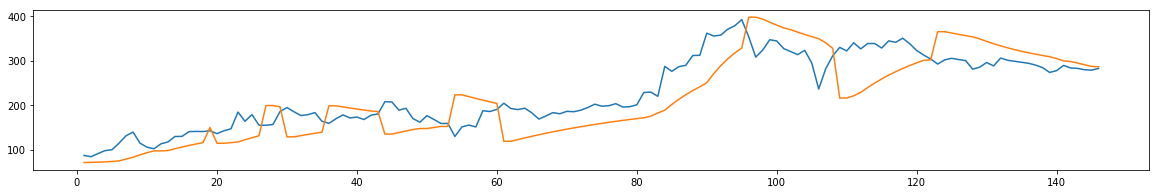

In [70]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="Close")
plt.plot(dash.index, dash['PSAR'] , label="PSAR")

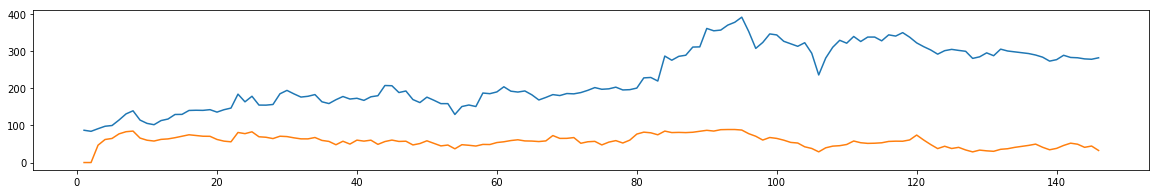

In [71]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="Close")
plt.plot(dash.index, dash['RSI'] , label="RSI")

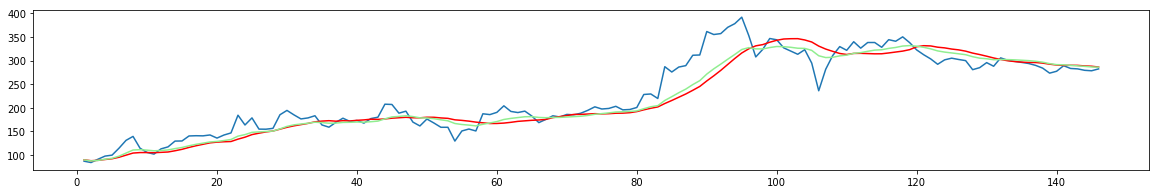

In [72]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="close")
plt.plot(dash.index, dash['SMA14'] , label="SMA14", c='red')
plt.plot(dash.index, dash['EMA14'] , label="SMA30",c='lightgreen')

In [73]:
dash.columns[1:28]

Index(['Open', 'Max', 'Min', 'Close', 'Volume', 'SMA14', 'SMA30', 'EMA14',
       'EMA30', 'Privot_Dot', 'Pct_Change', 'TR', 'R1', 'R2', 'R3', 'S1', 'S2',
       'S3', 'BB_Lower', 'BB_Mean', 'BB_Upper', 'EMA_12', 'EMA_26', 'MACD',
       'RSI', 'ATR', 'PSAR'],
      dtype='object')

In [74]:
dash.head()

,Date_Time,Open,Max,Min,Close,Volume,SMA14,SMA30,EMA14,EMA30,...,BB_Lower,BB_Mean,BB_Upper,EMA_12,EMA_26,MACD,RSI,ATR,PSAR,Direction
1,2017-05-16,93.54,93.54,86.00,87.06,983,89.955000,89.955000,89.748214,89.858500,...,-237.367870,89.955000,417.277870,89.713750,89.843654,-0.129904,0.000000,9.205357,71.093580,-1.0
2,2017-05-17,87.06,91.14,79.73,84.20,907,88.036667,88.036667,87.628778,87.845239,...,-264.292787,88.036667,440.366121,87.561732,87.815944,-0.254212,0.000000,10.089559,71.547909,1.0
3,2017-05-18,84.21,92.03,84.20,91.25,869,88.840000,88.840000,88.736612,88.783375,...,-226.210955,88.840000,403.890955,88.725974,88.775956,-0.049982,46.792105,11.175739,71.993151,1.0
4,2017-05-19,92.11,102.31,86.17,97.84,1159,90.640000,90.640000,91.111672,90.843976,...,-331.249272,90.640000,512.529272,91.202222,90.877945,0.324277,62.091762,12.470907,72.429488,1.0
5,2017-05-21,101.15,101.48,98.65,99.85,150,92.175000,92.175000,93.133565,92.605863,...,-390.272984,92.175000,574.622984,93.304087,92.674976,0.629111,64.958057,13.287476,73.624708,1.0


In [75]:
dash.to_csv('/home/ml/datasets/DASH1440_with_indicators.csv', sep=',', index=False)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


n_train = (dash['Date_Time'].count()*0.7).astype(int)

X = dash[dash.columns[1:28]]
y = dash['Direction']

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:] 

pipe = Pipeline([("scaler", StandardScaler()),("mlp",MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]))])

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {'mlp__activation':['tanh', 'relu', 'logistic'],
             'mlp__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Beste Genauigkeit nach Kreuzvalidierung: {:.2f}".format(grid.best_score_))
print("Bester Score auf den Testdaten: {:.2f}".format(grid.score(X_test, y_test)))
print("Beste Parameter: {}".format(grid.best_params_))

Beste Genauigkeit nach Kreuzvalidierung: 0.96
Bester Score auf den Testdaten: 0.95
Beste Parameter: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001}


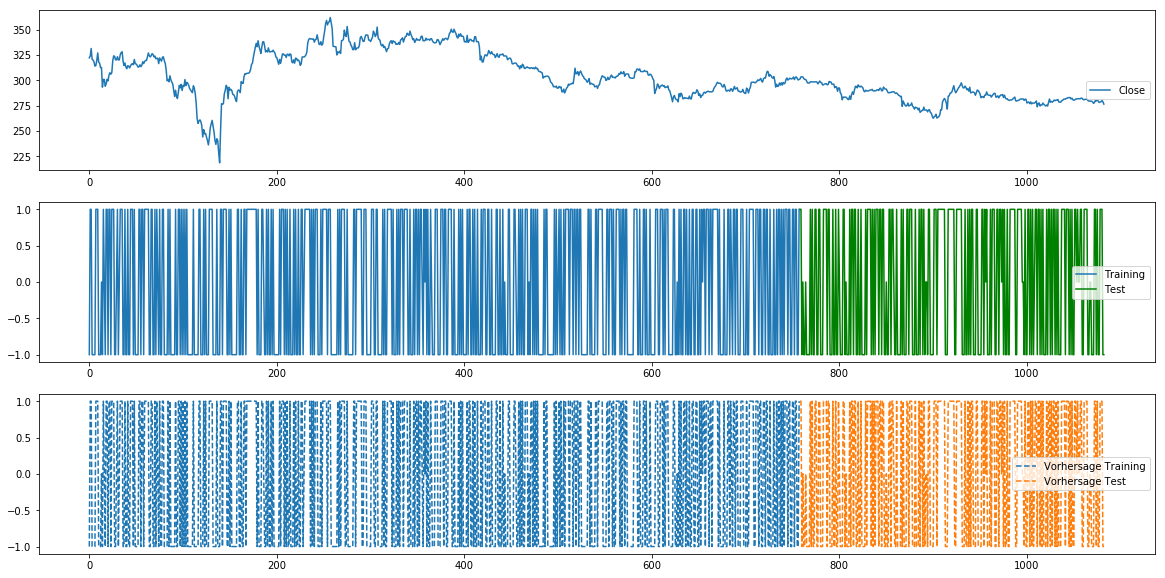

In [85]:
pipe.fit(X_test,y_test)
y_pred = pipe.predict(X_test)
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)

plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(range(0, len(y_test) + n_train), dash['Close'] , label="Close")
 
plt.legend(loc=('right'))
plt.subplot(312)
plt.plot(range(n_train), y_train, '-',label="Training")
plt.plot(range(n_train, len(y_test) + n_train), y_test, 'g-', label="Test")
plt.legend(loc=('right'))
plt.subplot(313)
plt.plot(range(n_train), y_pred_train, '--', label="Vorhersage Training")
plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Vorhersage Test")
plt.legend(loc=('right'))

In [17]:
import time
start_date = pd.Timestamp('2017-10-27')
test_vector_down = [281.11,284.50,274.70,279.50,8830,4338.79]
test_vector_up = [129.86,140.46,129.25,140.46,1169,1711.04]

In [18]:
print(pipe.predict(test_vector_up))
print(pipe.predict(test_vector_down))

[ 1.]
[ 1.]


/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1)